In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display

In [25]:
raw_df = pd.read_csv("meth_counts/GSE153594_Methylation_Counts.csv", sep=",", decimal=".",
                 dtype={"Chr": str, "Start": int, "End": int, "NZM9": float})

raw_df = raw_df[["Chr", "Start", "End", "NZM9"]]

display(raw_df.head(5))

,Chr,Start,End,NZM9
0,1,10003038,10003165,5.376344
1,1,10003166,10003208,3.472222
2,1,10003232,10003297,1.980198
3,1,10003298,10003339,24.719101
4,1,10003340,10003434,3.851641


In [26]:
raw_df['Chr'] = raw_df['Chr'].map(lambda x: f'chr{x}')

df_vh = raw_df[(raw_df.NZM9 > 75)]
df_hi = raw_df[(raw_df.NZM9 < 75) & (raw_df.NZM9 > 50)]
df_me = raw_df[(raw_df.NZM9 < 50) & (raw_df.NZM9 > 25)]
df_lw = raw_df[(raw_df.NZM9 < 25)]

nzm9_columns = {
    'very_high': df_vh["NZM9"].to_list(), 'high': df_hi["NZM9"].to_list(),
    'medium': df_me["NZM9"], 'low': df_lw["NZM9"]
}

del df_vh["NZM9"]
del df_hi["NZM9"]
del df_me["NZM9"]
del df_lw["NZM9"]

In [27]:
df_vh.to_csv("bed_files/vh_meth.bed", header=None, index=None, sep="\t")
df_hi.to_csv("bed_files/hi_meth.bed", header=None, index=None, sep="\t")
df_me.to_csv("bed_files/me_meth.bed", header=None, index=None, sep="\t")
df_lw.to_csv("bed_files/lw_meth.bed", header=None, index=None, sep="\t")

In [28]:
root = 'annotated_files'
files = ['vh_annotated', 'hi_annotated', 'me_annotated', 'lw_annotated']
meth_types = {'very_high': 4, 'high': 3, 'medium': 2, 'low': 1}

def get_label(raw_label):
    return raw_label.split('(')[0].capitalize()

raw_dfs = [pd.read_csv(f'{root}/{f}.txt', sep='\t') for f in files]    

for i, (df, mtype) in enumerate(zip(raw_dfs, meth_types)):
    df['NZM9'] = nzm9_columns[mtype]
    df['Meth type'] = [mtype] * len(df)
    df['Meth label'] = [meth_types[mtype]] * len(df)
    df['Label'] = df['Annotation'].apply(lambda x: get_label(x))
    df.to_csv(f'{root}/{files[i]}.csv')

dfs = [pd.read_csv(f'{root}/{f}.csv') for f in files]    
df = pd.concat(dfs, axis='index').reset_index()
df.to_csv("annotated_files/all_annotated.csv", index=False)

In [30]:
display(df.head(5))

,index,Unnamed: 0,PeakID,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,...,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type,NZM9,Meth type,Meth label,Label
0,0,0,81541,chr20,47267635,47267690,+,0,NaN,"intron (NM_020820, intron 22 of 39)",...,NaN,NaN,PREX1,NaN,NaN,NaN,98.039216,very_high,4,Intron
1,1,1,57846,chr17,982170,982227,+,0,NaN,"intron (NM_021962, intron 6 of 22)",...,NaN,NaN,ABR,NaN,NaN,NaN,93.548387,very_high,4,Intron
2,2,2,59977,chr19,1015760,1015912,+,0,NaN,"intron (NM_033420, intron 1 of 9)",...,NaN,NaN,C19orf6,NaN,NaN,NaN,93.922652,very_high,4,Intron
3,3,3,28361,chr12,6341735,6341819,+,0,NaN,"intron (NM_001769, intron 2 of 7)",...,NaN,NaN,CD9,NaN,NaN,NaN,96.103896,very_high,4,Intron
4,4,4,107811,chr6,133562640,133562679,+,0,NaN,"exon (NM_004100, exon 1 of 20)",...,NaN,NaN,EYA4,NaN,NaN,NaN,81.818182,very_high,4,Exon


In [29]:
df = pd.read_csv('annotated_files/all_annotated.csv')

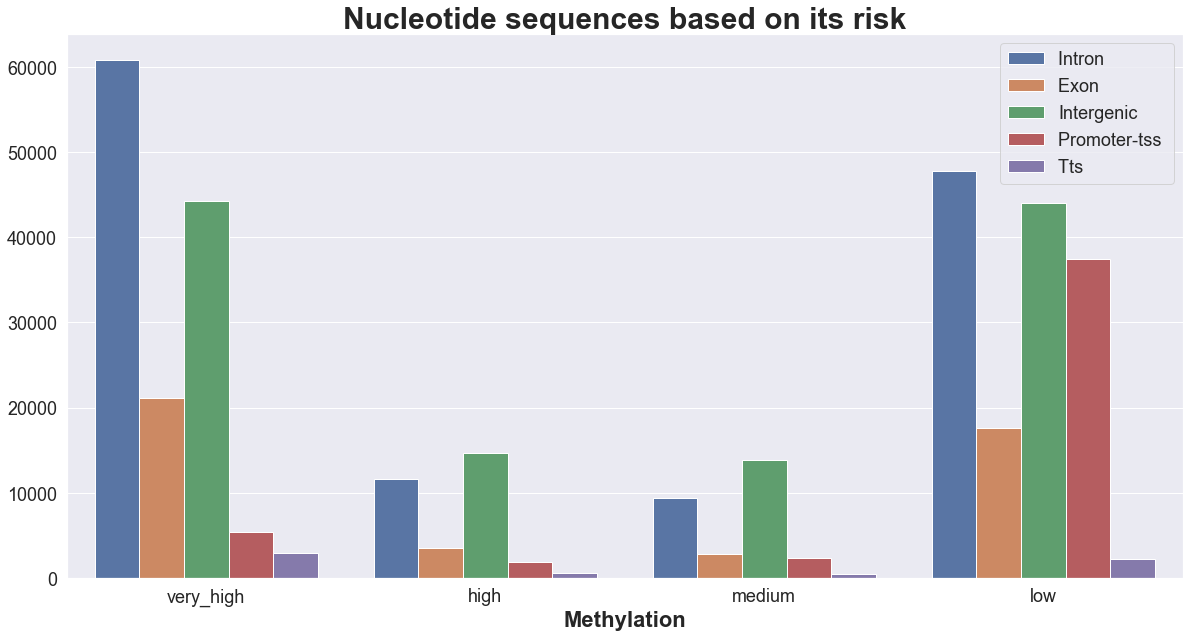

In [31]:
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
sns.set_theme(style="darkgrid")

ax = sns.countplot(x="Meth type", hue="Label", data=df)
plt.legend(fontsize=18)
ax.set_title('Nucleotide sequences based on its risk', weight='bold', fontsize=30)
ax.set_xlabel('Methylation', weight='bold', fontsize=22)
ax.set_ylabel('')
ax.tick_params(labelsize=18)

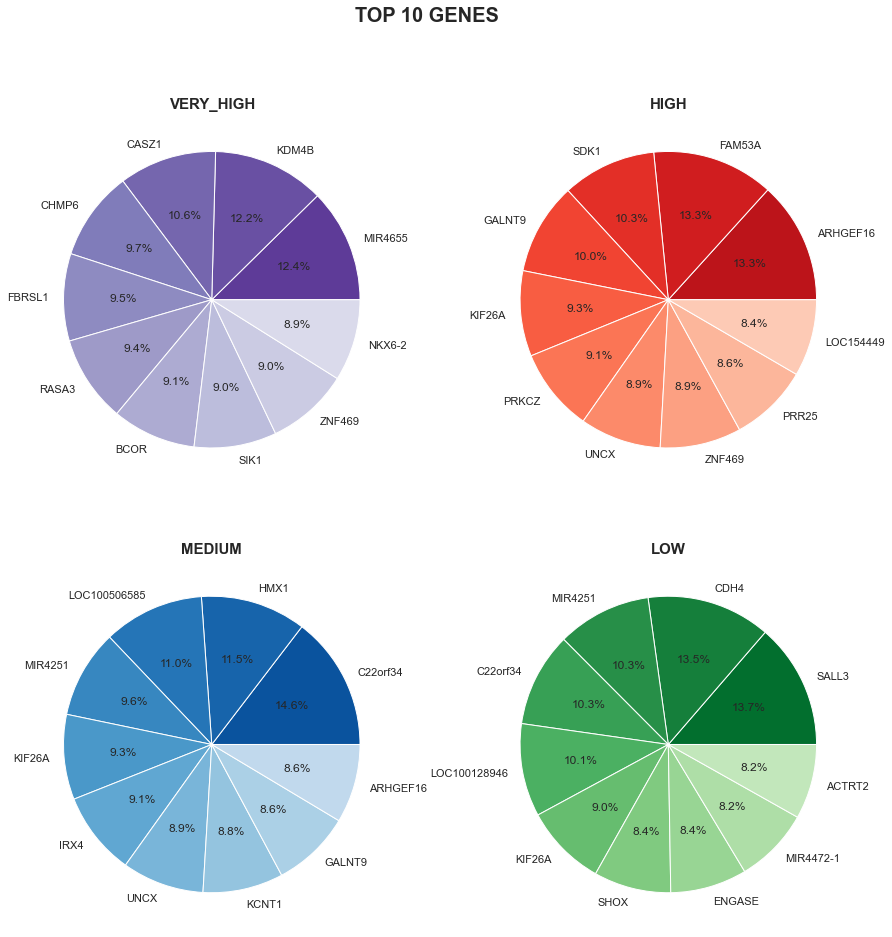

In [32]:
f, axs = plt.subplots(2, 2, figsize=(15,15))

colors = {
    'very_high': sorted(sns.color_palette('Purples', 15))[2:],
    'high': sorted(sns.color_palette('Reds_r', 14))[2:],
    'medium': sorted(sns.color_palette('Blues_r', 14))[1:],
    'low': sorted(sns.color_palette('Greens_r', 14))[1:]
}

plt.suptitle('TOP 10 GENES', weight='bold', fontsize=20)

counters = {}
for i, mtype in enumerate(meth_types):
    counters[mtype] = Counter(df[df['Meth type'] == mtype]['Gene Name'])
    
    common_genes = counters[mtype].most_common(10)
    common_genes_dict = {i[0] : i[1] for i in common_genes}
    
    plt.subplot(2, 2, i + 1)
    plt.pie(common_genes_dict.values(), labels=common_genes_dict.keys(), autopct='%1.1f%%', colors=colors[mtype])
    plt.title(mtype.upper(), weight='bold', fontsize=15)
#     plt.legend()
    plt.plot()

plt.show()

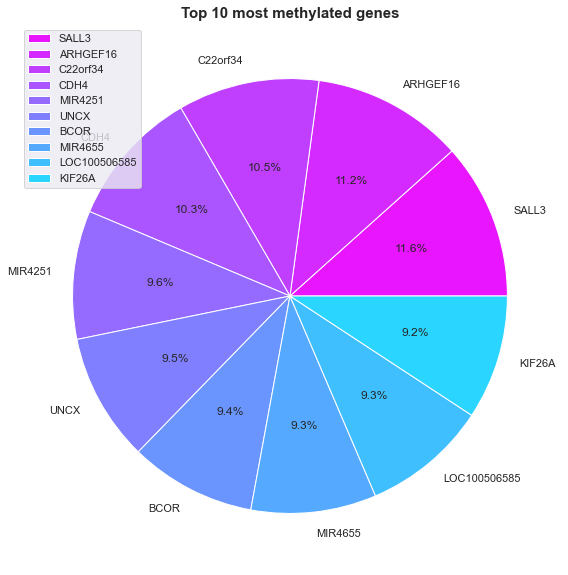

In [38]:
colors = reversed(sns.color_palette('cool', 11)[1:])

counter = Counter(df['Gene Name'])
common_genes = counter.most_common(10)
common_genes_dict = {i[0] : i[1] for i in common_genes}

plt.pie(common_genes_dict.values(), labels=common_genes_dict.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Top 10 most methylated genes', weight='bold', fontsize=15)
plt.legend()
plt.plot()
plt.show()